In [4]:
import numpy as np
import json
from glob import glob
from PIL import Image, ImageDraw
from os import path, mkdir
from numpy.linalg import lstsq
import imutils
from matplotlib import pyplot as plot
from skimage import io,transform
import cv2  


np.set_printoptions(threshold=np.inf)

image_folder = "2019-06-19-panorama-billeder-exiftool-DJI-P4P/*.JPG"

def to_surface_meters(lattitude, longitude, altitude):
    """Takes GPS coordinates and returns approximate meters"""
    m_pr_deg = 40075000 / 360
    a = np.array([m_pr_deg * lattitude,
                     np.cos(lattitude * np.pi / 180) * m_pr_deg * longitude,
                     altitude])
#     B =np.reshape(a,(3,1)) 
    return a



def meters_to_degree(meter_la, meter_lo):
    """Takes GPS coordinates and returns approximate meters"""
    m_pr_deg = 40075000 / 360
    temp = meter_la/m_pr_deg
    a =np.array([meter_la/m_pr_deg,meter_lo/(np.cos(temp* np.pi/180) * m_pr_deg)])
#     B = np.reshape(a,(2,1))
    return a

def rotation(yaw, pitch, roll):
    """Takes yaw, pitch and roll; returns rotation matrix (PATB standard)"""
    deg = np.pi / 180
    yaw, pitch, roll = yaw * deg, pitch * deg, roll * deg
    Ryaw = np.array([[np.cos(yaw), np.sin(yaw), 0],
                     [-np.sin(yaw), np.cos(yaw), 0],
                     [0, 0, 1]])
    Rpitch = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                       [0, 1, 0],
                       [-np.sin(pitch), 0, np.cos(pitch)]])
    Rroll = np.array([[1, 0, 0],
                      [0, np.cos(roll), np.sin(roll)],
                      [0, -np.sin(roll), np.cos(roll)]])
    # Using PATB standard; yaw, pitch, roll; in that order
    return Rroll @ Rpitch @ Ryaw  # @ --> matrix dot


def STD_GPS():
    """Change-of-basis matrix; GPS to camera coordinates"""
    return np.array([[0, 1, 0],
                     [0, 0, -1],
                     [1, 0, 0]])


class camera:
    """Construct a useful camera object from a dictionary of parameters"""
    def __init__(self, parameters, image=None):
        self.name, self.ext = path.splitext(parameters['FileName'])
        self.image = image
        self.imsize = np.array([int(parameters["ImageWidth"]),
                                int(parameters["ImageHeight"])])
        # focal length in pixels/meters
        self.f = parameters['CalibratedFocalLength']
        # optical center in pixels
        self.cx = parameters['CalibratedOpticalCenterX']
        self.cy = parameters['CalibratedOpticalCenterY']
        # Intrisic camera matrix
        self.K = np.array([[self.f, 0, self.cx],
                           [0, self.f, self.cy],
                           [0, 0, 1]])
        self.pos = to_surface_meters(parameters["GPSLatitude"],
                                     parameters["GPSLongitude"],
                                     parameters["GPSAltitude"])
        self.R = STD_GPS() @ rotation(parameters['CameraYaw'],
                                      parameters['CameraPitch'],
                                      parameters['CameraRoll'])
        self.t = -self.R @ self.pos
        print("t:",self.t)
        # Extrinsic camera matrix
        self.Rt = np.c_[self.R, self.t]
        # Projection matrix
        self.P = self.K @ np.c_[self.R, self.t]


cameras = []
testR = []
for f in glob(image_folder):
    im = Image.open(f)
    f_no_ext = path.splitext(f)[0]
    with open(f_no_ext + ".json") as jf:
        cameras.append(camera(json.load(jf)[0], im))
N = len(cameras)

Projection = []
for i,cam in enumerate(cameras):
    Projection.append(cam.P)

[[m11,m12,m13,m14],[m21,m22,m23,m24],[m31,m32,m33,m34]] = Projection[0]

[x1,y1] = [0,0]
[x2,y2] = [5472,0]
[x3,y3] = [5472,3648]
[x4,y4] = [0,3648]

def solve_fun(x,y):
    A = np.mat([[m11-m31*x,m12-m32*x],[m21-m31*y,m22-m32*y]])    # 构造系数矩阵 A
    b = np.mat([m34*x-m14,m34*y-m24]).T       # 构造转置矩阵 b （这里必须为列向量）
    r = np.linalg.solve(A,b)  # 调用 solve 函数求解
    result = meters_to_degree(r[0],r[1])
    return result

r1 = solve_fun(x1,y1)
r2 = solve_fun(x2,y2)
r3 = solve_fun(x3,y3)
r4 = solve_fun(x4,y4) 

print(r1)

t: [-4.79057231e+06  4.00807022e+06  1.00739000e+02]
t: [-4790572.31205425  3478114.94421889 -1991819.05854469]
t: [-4790572.31977545  1700312.44364682 -3629540.61060975]
t: [-5989470.14541606 -1533116.54441334   888833.07807419]
t: [-5866377.83526895    -7385.63895017  2144709.38293259]
t: [-6235026.85905541   157463.13562894  -337442.41530011]
[[[55.69376798]]

 [[12.10041302]]]


In [5]:
def three_two(coor):
    point3d = coor[0],coor[1],0
    p3d = to_surface_meters(*point3d)
    a = np.array(np.r_[p3d, 1])
    temp1 = a[0][0][0]
    temp2 = a[1][0][0]
    A = np.array([[temp1],[temp2],[0],[1]])
    p2d = Projection[1] @ A # homogeneous coordinates
    p2d = p2d[:2] / p2d[2]  # to inhomogeneous (normal) coordinates
    return p2d
    
newr1 = three_two(r1)
newr2 = three_two(r2)
newr3 = three_two(r3)
newr4 = three_two(r4)



In [7]:
test_folder = ("test/", ".png")
im = cv2.imread('2019-06-19-panorama-billeder-exiftool-DJI-P4P/PANO0002.JPG')
im2=im.copy()

translated = cv2.copyMakeBorder(im2,0,4000,1675,1675, cv2.BORDER_CONSTANT,value=[255,255,255])#(up,down,left,right)

pt1 = (int(newr1[0][0])+1675, int(newr1[1][0]))
pt2 = (int(newr2[0][0])+1675, int(newr2[1][0]))
pt3 = (int(newr3[0][0])+1675, int(newr3[1][0]))
pt4 = (int(newr4[0][0])+1675, int(newr4[1][0]))
point_color = (0, 255, 0) # BGR
thickness = 10 
lineType = 4
cv2.line(translated, pt1, pt2, point_color, thickness, lineType)
cv2.line(translated, pt2, pt3, point_color, thickness, lineType)
cv2.line(translated, pt3, pt4, point_color, thickness, lineType)
cv2.line(translated, pt4, pt1, point_color, thickness, lineType)


io.imsave(test_folder[0]+'1'+test_folder[1],translated)

In [18]:

img=im.copy()
warp_image=cv2.imread('2019-06-19-panorama-billeder-exiftool-DJI-P4P/PANO0001.JPG')
warp_image=np.array(warp_image)
w=img.shape[1]
h=img.shape[0]
print(warp_image.shape)
print(img.shape)

(3648, 5472, 3)
(3648, 5472, 3)


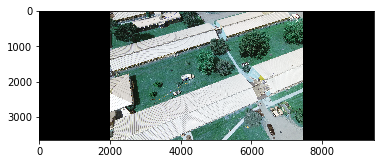

In [14]:
padding=np.zeros([3648,2000,3],dtype=np.uint8)
padding_img=np.hstack([padding,img,padding])
plot.imshow(padding_img)

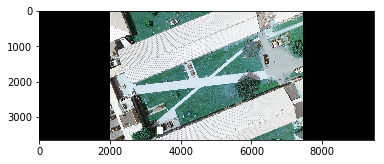

In [31]:
padding_warpimage=np.hstack([padding,warp_image,padding])
plot.imshow(padding_warpimage)

In [32]:
#points in image 1
X1 = [0,0]
X2 = [5472,0]
X3 = [5472,3648]
X4 = [0,3648]
def getpoints(p1,p2,p3,p4):
    points=[]
    points.append(p1)
    points.append(p2)
    points.append(p3)
    points.append(p4)
    points=np.array(points)
    return points

src=getpoints(X1,X2,X3,X4)
dst=getpoints(newr1,newr2,newr3,newr4)
print(src)
print(dst)

[[   0    0]
 [5472    0]
 [5472 3648]
 [   0 3648]]
[[[  282.49671511]
  [ 2038.07052759]]

 [[ 5189.67811911]
  [ 2038.07052758]]

 [[ 7144.39261117]
  [ 7309.02850336]]

 [[-1672.07849584]
  [ 7309.0285033 ]]]


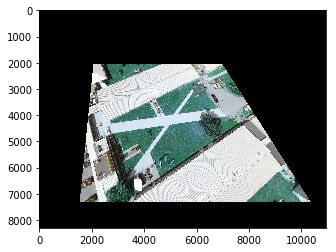

In [41]:
H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
im_out =  cv2.warpPerspective(padding_warpimage, H, (2*w, 2*h+1000))
plot.imshow(im_out)

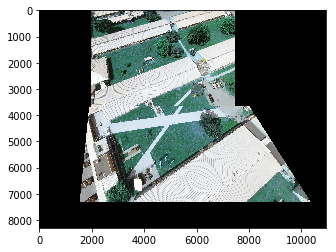

In [42]:
im_out[0:padding_img.shape[0],0:padding_img.shape[1]]=padding_img
plot.imshow(im_out)
io.imsave(test_folder[0]+'1_stitching'+test_folder[1],im_out)

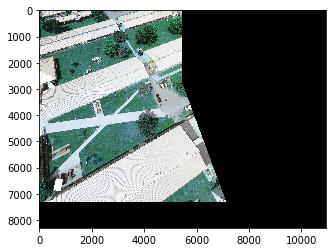

In [30]:



im_out2 =  cv2.warpPerspective(warp_image, H, (2*w, 2*h+1000))
im_out2[0:img.shape[0],0:img.shape[1]]=img
plot.imshow(im_out2)
io.imsave(test_folder[0]+'1_stitching2'+test_folder[1],im_out2)